In [1]:
import scanpy as sc
import pandas as pd
import re, os
import numpy as np
import scvi
import tqdm as notebook_tqdm

/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
#!curl -O https://cf.10xgenomics.com/samples/cell-exp/8.0.0/HumanColonCancer_Flex_Multiplex/HumanColonCancer_Flex_Multiplex_count_filtered_feature_bc_matrix.h5
#!curl -O https://cf.10xgenomics.com/samples/cell-exp/8.0.0/HumanColonCancer_Flex_Multiplex/HumanColonCancer_Flex_Multiplex_aggregation.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  405M  100  405M    0     0   156M      0  0:00:02  0:00:02 --:--:--  156M


In [2]:
adata = sc.read_10x_h5('HumanColonCancer_Flex_Multiplex_count_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
print(f"Loaded matrix: {adata.n_obs:,} barcodes × {adata.n_vars:,} genes")
adata
#adata.obs cell barcodes
#adata.var #genes 
#adata.X # counts
#adata.X.shape

/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Loaded matrix: 279,609 barcodes × 18,082 genes


/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 279609 × 18082
    var: 'gene_ids', 'feature_types', 'genome'

## Extract Patient 2 Data
The filtered_feature is matrices across 8 tissue blocks, following blocks extract the samples we need for downstream analysis.

In [3]:
#read aggregation csv
agg_data = 'HumanColonCancer_Flex_Multiplex_aggregation.csv'
agg_data = pd.read_csv(agg_data)
#print(agg_data)


#lowercase column names/spaces 
agg_data.columns = agg_data.columns.str.strip().str.lower()

#create dictioanry of sampleid
suffix_map_sample = {str(i + 1): sid for i, sid in enumerate(agg_data["sample_id"])}

# for key, value in list(suffix_map_sample.items())[:5]:
#      print(key, value)

# check to see agg_csv has 32 lines confirm
# print(f"Aggregation CSV contains {len(agg_data)} rows")



In [4]:
#barcode names 
#adata.obs

#grabs the last emenet of the suffix 1, 2, 3.. etc 
adata.obs["suffix"] = adata.obs_names.str.split("-").str[-1]

#map the 1, 2,3, to the sameple name in our suffix dictionary
adata.obs["sample_id"] = adata.obs["suffix"].map(suffix_map_sample)

# check mapping 
adata.obs[["suffix", "sample_id"]].head(2)


# Parse the patient tag to make human readable
def get_patient_tag(s: str | None) -> str:
    if s is None:
        return "unknown"
    m = re.search(r"_P(\d+)(CRC|NAT)", s)
    return f"P{m.group(1)}{m.group(2)}" if m else "unknown"

adata.obs["patient_tag"] = adata.obs["sample_id"].map(get_patient_tag)

adata_p2_p5 = adata[adata.obs["patient_tag"].isin(["P2CRC", "P5CRC"])].copy()
print("After patient subset:", adata_p2_p5.shape)
print(adata.obs["patient_tag"].value_counts())

After patient subset: (66548, 18082)
patient_tag
P3CRC    50652
P2CRC    41933
P3NAT    41237
P5NAT    36873
P2NAT    32801
P4CRC    31007
P5CRC    24615
P1CRC    20491
Name: count, dtype: int64


In [8]:
#save p2
p2_cells = adata_p2_p5[adata_p2_p5.obs["patient_tag"].str.startswith("P2CRC")].copy()
p2_cells.write_h5ad("P2_Flex_only.h5ad", compression="gzip")
print(p2_cells.obs["patient_tag"].value_counts())

#save p5
p5_cells = adata_p2_p5[adata_p2_p5.obs["patient_tag"] == "P5CRC"].copy()
p5_cells.write_h5ad("P5_Flex_only.h5ad", compression="gzip")
print((p5_cells.obs["patient_tag"].value_counts()))

patient_tag
P2CRC    41933
Name: count, dtype: int64
patient_tag
P5CRC    24615
Name: count, dtype: int64


In [12]:
## Doublet Removal 
Begin single cell processing

SyntaxError: invalid syntax (1111840296.py, line 2)

In [9]:
p2_adata = sc.read_h5ad('P2_Flex_only.h5ad')
p2_adata
# print(p5_adata)
# print(adata.obs.columns)
# print(adata.obs.tail())

AnnData object with n_obs × n_vars = 41933 × 18082
    obs: 'suffix', 'sample_id', 'patient_tag'
    var: 'gene_ids', 'feature_types', 'genome'

In [10]:
# only keep genes bound in at least 10 of the cells 
sc.pp.filter_genes(p2_adata, min_cells = 10)
print(p2_adata)
# keep 2000 of those genes
sc.pp.highly_variable_genes(p2_adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
print(p2_adata)

AnnData object with n_obs × n_vars = 41933 × 15879
    obs: 'suffix', 'sample_id', 'patient_tag'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
AnnData object with n_obs × n_vars = 41933 × 2000
    obs: 'suffix', 'sample_id', 'patient_tag'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'


In [11]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("GPU not visible inside this kernel.")

!which python

CUDA available: True
Device count: 3
Device name: NVIDIA L40S
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/bin/python


In [12]:
#train model to have the prediction for doublet
scvi.model.SCVI.setup_anndata(p2_adata)
vae = scvi.model.SCVI(p2_adata)
vae.train()

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/home/jjoseph/.local/lib/python3.10/site-package ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: 

Epoch 191/191: 100%|█| 191/191 [04:47<00:00,  1.48s/it, v_num=1, train_loss_step=350, train_lo

`Trainer.fit` stopped: `max_epochs=191` reached.


Epoch 191/191: 100%|█| 191/191 [04:47<00:00,  1.50s/it, v_num=1, train_loss_step=350, train_lo


In [13]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/home/jjoseph/.local/lib/python3.10/site-package ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: 

Epoch 163/400:  41%|▍| 163/400 [04:07<06:00,  1.52s/it, v_num=1, train_loss_step=0.483, train_
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.411. Signaling Trainer to stop.


In [19]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)
df

/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


,doublet,singlet,prediction
AAACAAGCAACAGCACACTTTAGG-1,0.914527,0.085473,doublet
AAACAAGCAACAGCTAACTTTAGG-1,0.396838,0.603162,singlet
AAACAAGCAACTGTTCACTTTAGG-1,0.019746,0.980254,singlet
AAACAAGCAAGGCCTGACTTTAGG-1,0.212421,0.787579,singlet
AAACAAGCACATAGTGACTTTAGG-1,0.720672,0.279328,doublet
...,...,...,...
TTTGGCGGTTCCGGGTACTTTAGG-7,0.011305,0.988695,singlet
TTTGTGAGTCCGCTAAACTTTAGG-7,0.006196,0.993804,singlet
TTTGTGAGTCCGGGTTACTTTAGG-7,0.284501,0.715499,singlet
TTTGTGAGTCTTTATCACTTTAGG-7,0.255619,0.744381,singlet


In [20]:
df['dif'] = df.doublet - df.singlet
df

,doublet,singlet,prediction,dif
AAACAAGCAACAGCACACTTTAGG-1,0.914527,0.085473,doublet,0.829055
AAACAAGCAACAGCTAACTTTAGG-1,0.396838,0.603162,singlet,-0.206324
AAACAAGCAACTGTTCACTTTAGG-1,0.019746,0.980254,singlet,-0.960508
AAACAAGCAAGGCCTGACTTTAGG-1,0.212421,0.787579,singlet,-0.575157
AAACAAGCACATAGTGACTTTAGG-1,0.720672,0.279328,doublet,0.441343
...,...,...,...,...
TTTGGCGGTTCCGGGTACTTTAGG-7,0.011305,0.988695,singlet,-0.977390
TTTGTGAGTCCGCTAAACTTTAGG-7,0.006196,0.993804,singlet,-0.987608
TTTGTGAGTCCGGGTTACTTTAGG-7,0.284501,0.715499,singlet,-0.430998
TTTGTGAGTCTTTATCACTTTAGG-7,0.255619,0.744381,singlet,-0.488762


In [21]:
df.groupby('prediction').count()

,doublet,singlet,dif
prediction,,,
doublet,16181,16181,16181
singlet,25752,25752,25752


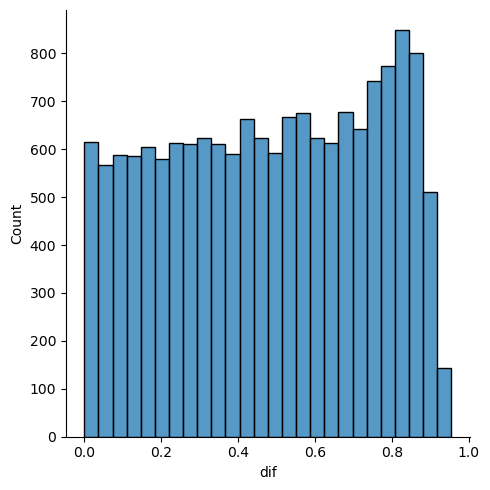

In [22]:
import seaborn as sns
sns.displot(df[df.prediction == 'doublet'], x = 'dif')

In [23]:
doublets = df[(df.prediction == 'doublet')]
doublets

,doublet,singlet,prediction,dif
AAACAAGCAACAGCACACTTTAGG-1,0.914527,0.085473,doublet,0.829055
AAACAAGCACATAGTGACTTTAGG-1,0.720672,0.279328,doublet,0.441343
AAACAAGCAGCATTTCACTTTAGG-1,0.592565,0.407435,doublet,0.185129
AAACAAGCATCAGGTAACTTTAGG-1,0.910494,0.089506,doublet,0.820988
AAACCAATCAGGCATGACTTTAGG-1,0.768778,0.231222,doublet,0.537556
...,...,...,...,...
TTTGCGGGTCAGGAACACTTTAGG-7,0.931920,0.068080,doublet,0.863840
TTTGCGGGTTAAGGATACTTTAGG-7,0.740279,0.259721,doublet,0.480559
TTTGCTGAGTGAGTCGACTTTAGG-7,0.570834,0.429167,doublet,0.141667
TTTGGCGGTGGCGTAGACTTTAGG-7,0.917161,0.082839,doublet,0.834323


In [24]:
p5_adata = sc.read_h5ad('P2_Flex_only.h5ad')
p5_adata.obs

,suffix,sample_id,patient_tag
AAACAAGCAACAGCACACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC
AAACAAGCAACAGCTAACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC
AAACAAGCAACTGTTCACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC
AAACAAGCAAGGCCTGACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC
AAACAAGCACATAGTGACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC
...,...,...,...
TTTGGCGGTTCCGGGTACTTTAGG-7,7,20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC...,P2CRC
TTTGTGAGTCCGCTAAACTTTAGG-7,7,20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC...,P2CRC
TTTGTGAGTCCGGGTTACTTTAGG-7,7,20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC...,P2CRC
TTTGTGAGTCTTTATCACTTTAGG-7,7,20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC...,P2CRC


In [25]:
#does it match the doublet in the inital p5_Data
p5_adata.obs['doublet'] = p5_adata.obs.index.isin(doublets.index)
p5_adata.obs

,suffix,sample_id,patient_tag,doublet
AAACAAGCAACAGCACACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,True
AAACAAGCAACAGCTAACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,False
AAACAAGCAACTGTTCACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,False
AAACAAGCAAGGCCTGACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,False
AAACAAGCACATAGTGACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,True
...,...,...,...,...
TTTGGCGGTTCCGGGTACTTTAGG-7,7,20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC...,P2CRC,False
TTTGTGAGTCCGCTAAACTTTAGG-7,7,20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC...,P2CRC,False
TTTGTGAGTCCGGGTTACTTTAGG-7,7,20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC...,P2CRC,False
TTTGTGAGTCTTTATCACTTTAGG-7,7,20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC...,P2CRC,False


In [26]:
#filter out cells we want to remove the doublets
p5_adata = p5_adata[~p5_adata.obs.doublet]
p5_adata.obs

,suffix,sample_id,patient_tag,doublet
AAACAAGCAACAGCTAACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,False
AAACAAGCAACTGTTCACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,False
AAACAAGCAAGGCCTGACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,False
AAACAAGCAGGGCTATACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,False
AAACAAGCATTGTGAGACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,False
...,...,...,...,...
TTTGGCGGTTAGTGCTACTTTAGG-7,7,20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC...,P2CRC,False
TTTGGCGGTTCCGGGTACTTTAGG-7,7,20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC...,P2CRC,False
TTTGTGAGTCCGCTAAACTTTAGG-7,7,20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC...,P2CRC,False
TTTGTGAGTCCGGGTTACTTTAGG-7,7,20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC...,P2CRC,False


In [ ]:
## Preprocessing

In [41]:
p5_adata.var[p5_adata.var.index.str.startswith('MT-')]

,gene_ids,feature_types,genome,mt,ribo
MT-ND1,ENSG00000198888,Gene Expression,GRCh38,True,False
MT-ND2,ENSG00000198763,Gene Expression,GRCh38,True,False
MT-CO2,ENSG00000198712,Gene Expression,GRCh38,True,False
MT-ATP6,ENSG00000198899,Gene Expression,GRCh38,True,False
MT-CO3,ENSG00000198938,Gene Expression,GRCh38,True,False
MT-ND3,ENSG00000198840,Gene Expression,GRCh38,True,False
MT-ND4L,ENSG00000212907,Gene Expression,GRCh38,True,False
MT-ND4,ENSG00000198886,Gene Expression,GRCh38,True,False
MT-ND5,ENSG00000198786,Gene Expression,GRCh38,True,False
MT-ND6,ENSG00000198695,Gene Expression,GRCh38,True,False


In [42]:
p5_adata.var['mt'] = p5_adata.var.index.str.startswith('MT-')
p5_adata.var

,gene_ids,feature_types,genome,mt,ribo
SAMD11,ENSG00000187634,Gene Expression,GRCh38,False,False
NOC2L,ENSG00000188976,Gene Expression,GRCh38,False,False
KLHL17,ENSG00000187961,Gene Expression,GRCh38,False,False
PLEKHN1,ENSG00000187583,Gene Expression,GRCh38,False,False
PERM1,ENSG00000187642,Gene Expression,GRCh38,False,False
...,...,...,...,...,...
MT-ND4L,ENSG00000212907,Gene Expression,GRCh38,True,False
MT-ND4,ENSG00000198886,Gene Expression,GRCh38,True,False
MT-ND5,ENSG00000198786,Gene Expression,GRCh38,True,False
MT-ND6,ENSG00000198695,Gene Expression,GRCh38,True,False


In [43]:
import pandas as pd

ribo_genes = pd.read_table("rib.txt", skiprows=2, header=None)
print(ribo_genes.head())


        0
0     FAU
1  MRPL13
2   RPL10
3  RPL10A
4  RPL10L


In [44]:
ribo_genes[0].values

array(['FAU', 'MRPL13', 'RPL10', 'RPL10A', 'RPL10L', 'RPL11', 'RPL12',
       'RPL13', 'RPL13A', 'RPL14', 'RPL15', 'RPL17', 'RPL18', 'RPL18A',
       'RPL19', 'RPL21', 'RPL22', 'RPL22L1', 'RPL23', 'RPL23A', 'RPL24',
       'RPL26', 'RPL26L1', 'RPL27', 'RPL27A', 'RPL28', 'RPL29', 'RPL3',
       'RPL30', 'RPL31', 'RPL32', 'RPL34', 'RPL35', 'RPL35A', 'RPL36',
       'RPL36A', 'RPL36AL', 'RPL37', 'RPL37A', 'RPL38', 'RPL39', 'RPL3L',
       'RPL4', 'RPL41', 'RPL5', 'RPL6', 'RPL7', 'RPL7A', 'RPL8', 'RPL9',
       'RPLP0', 'RPLP1', 'RPLP2', 'RPS10', 'RPS11', 'RPS12', 'RPS13',
       'RPS15', 'RPS15A', 'RPS16', 'RPS17', 'RPS18', 'RPS19', 'RPS2',
       'RPS20', 'RPS21', 'RPS23', 'RPS24', 'RPS25', 'RPS26', 'RPS27',
       'RPS27A', 'RPS27L', 'RPS28', 'RPS29', 'RPS3', 'RPS3A', 'RPS4X',
       'RPS4Y1', 'RPS5', 'RPS6', 'RPS7', 'RPS8', 'RPS9', 'RPSA',
       'RSL24D1', 'RSL24D1P11', 'UBA52'], dtype=object)

In [46]:
p5_adata.var['ribo'] = p5_adata.var_names.isin(ribo_genes[0].values)

In [49]:
p5_adata.var

,gene_ids,feature_types,genome,mt,ribo
SAMD11,ENSG00000187634,Gene Expression,GRCh38,False,False
NOC2L,ENSG00000188976,Gene Expression,GRCh38,False,False
KLHL17,ENSG00000187961,Gene Expression,GRCh38,False,False
PLEKHN1,ENSG00000187583,Gene Expression,GRCh38,False,False
PERM1,ENSG00000187642,Gene Expression,GRCh38,False,False
...,...,...,...,...,...
MT-ND4L,ENSG00000212907,Gene Expression,GRCh38,True,False
MT-ND4,ENSG00000198886,Gene Expression,GRCh38,True,False
MT-ND5,ENSG00000198786,Gene Expression,GRCh38,True,False
MT-ND6,ENSG00000198695,Gene Expression,GRCh38,True,False


In [50]:
p5_adata.obs

,suffix,sample_id,patient_tag,doublet
AAACAAGCAACAGCTAACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,False
AAACAAGCAACTGTTCACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,False
AAACAAGCAAGGCCTGACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,False
AAACAAGCAGGGCTATACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,False
AAACAAGCATTGTGAGACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,False
...,...,...,...,...
TTTGGCGGTTAGTGCTACTTTAGG-7,7,20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC...,P2CRC,False
TTTGGCGGTTCCGGGTACTTTAGG-7,7,20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC...,P2CRC,False
TTTGTGAGTCCGCTAAACTTTAGG-7,7,20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC...,P2CRC,False
TTTGTGAGTCCGGGTTACTTTAGG-7,7,20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC...,P2CRC,False


In [51]:
sc.pp.calculate_qc_metrics(p5_adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)


In [55]:
p5_adata.var.sort_values('n_cells_by_counts')


,gene_ids,feature_types,genome,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
TSPY1,ENSG00000258992,Gene Expression,GRCh38,False,False,0,0.000000,100.000000,0.0
WNT1,ENSG00000125084,Gene Expression,GRCh38,False,False,0,0.000000,100.000000,0.0
C1QL4,ENSG00000186897,Gene Expression,GRCh38,False,False,0,0.000000,100.000000,0.0
CA6,ENSG00000131686,Gene Expression,GRCh38,False,False,0,0.000000,100.000000,0.0
SPANXN1,ENSG00000203923,Gene Expression,GRCh38,False,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...,...,...,...
MT-ND4,ENSG00000198886,Gene Expression,GRCh38,True,False,17382,3.449868,32.502330,88841.0
MT-ATP6,ENSG00000198899,Gene Expression,GRCh38,True,False,20101,5.771435,21.943927,148626.0
MT-CO2,ENSG00000198712,Gene Expression,GRCh38,True,False,20292,6.057083,21.202237,155982.0
TMSB4X,ENSG00000205542,Gene Expression,GRCh38,False,False,20816,6.004854,19.167443,154637.0


In [76]:
sc.pp.filter_genes(p5_adata, min_cells=3)

In [77]:
p5_adata.var.sort_values('n_cells_by_counts')

,gene_ids,feature_types,genome,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
BRINP2,ENSG00000198797,Gene Expression,GRCh38,False,False,3,0.000116,99.988350,3.0,3
ARG1,ENSG00000118520,Gene Expression,GRCh38,False,False,3,0.000116,99.988350,3.0,3
EPHA8,ENSG00000070886,Gene Expression,GRCh38,False,False,3,0.000116,99.988350,3.0,3
ACOT12,ENSG00000172497,Gene Expression,GRCh38,False,False,3,0.000116,99.988350,3.0,3
LCN15,ENSG00000177984,Gene Expression,GRCh38,False,False,3,0.000116,99.988350,3.0,3
...,...,...,...,...,...,...,...,...,...,...
MT-ND4,ENSG00000198886,Gene Expression,GRCh38,True,False,17382,3.449868,32.502330,88841.0,16996
MT-ATP6,ENSG00000198899,Gene Expression,GRCh38,True,False,20101,5.771435,21.943927,148626.0,19596
MT-CO2,ENSG00000198712,Gene Expression,GRCh38,True,False,20292,6.057083,21.202237,155982.0,19785
TMSB4X,ENSG00000205542,Gene Expression,GRCh38,False,False,20816,6.004854,19.167443,154637.0,20417


In [78]:
p5_adata.obs.sort_values('n_genes_by_counts')
#sc.pp.filter_cells(p5_adata, min_genes=200)

,suffix,sample_id,patient_tag,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes
ATCTTAGGTGAACCAAACTTTAGG-3,3,20k_HumanColonCancer_Flex_Multiplex_P1L2_P2CRC...,P2CRC,False,200,239.0,6.0,2.510460,0.0,0.000000,200
CATTAGGCAAGGCCATACTTTAGG-7,7,20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC...,P2CRC,False,200,323.0,25.0,7.739938,0.0,0.000000,200
GACCTTCAGTAATTGGACTTTAGG-7,7,20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC...,P2CRC,False,200,209.0,3.0,1.435407,0.0,0.000000,200
TGTTAGTTCCCTCGTCACTTTAGG-3,3,20k_HumanColonCancer_Flex_Multiplex_P1L2_P2CRC...,P2CRC,False,200,224.0,4.0,1.785714,0.0,0.000000,200
CAATGGGTCAGGTCGAACTTTAGG-5,5,20k_HumanColonCancer_Flex_Multiplex_P1L3_P2CRC...,P2CRC,False,200,389.0,5.0,1.285347,0.0,0.000000,200
...,...,...,...,...,...,...,...,...,...,...,...
GTGGCTAAGGAACCATACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,False,9182,78211.0,2684.0,3.431742,52.0,0.066487,9181
CGCTACGTCCCACATAACTTTAGG-5,5,20k_HumanColonCancer_Flex_Multiplex_P1L3_P2CRC...,P2CRC,False,9387,86573.0,5595.0,6.462754,70.0,0.080857,9386
CAATACTTCCATAACTACTTTAGG-5,5,20k_HumanColonCancer_Flex_Multiplex_P1L3_P2CRC...,P2CRC,False,9763,105373.0,2994.0,2.841335,108.0,0.102493,9760
CAGATTCGTCCATCCTACTTTAGG-5,5,20k_HumanColonCancer_Flex_Multiplex_P1L3_P2CRC...,P2CRC,False,9867,94773.0,4255.0,4.489675,65.0,0.068585,9867


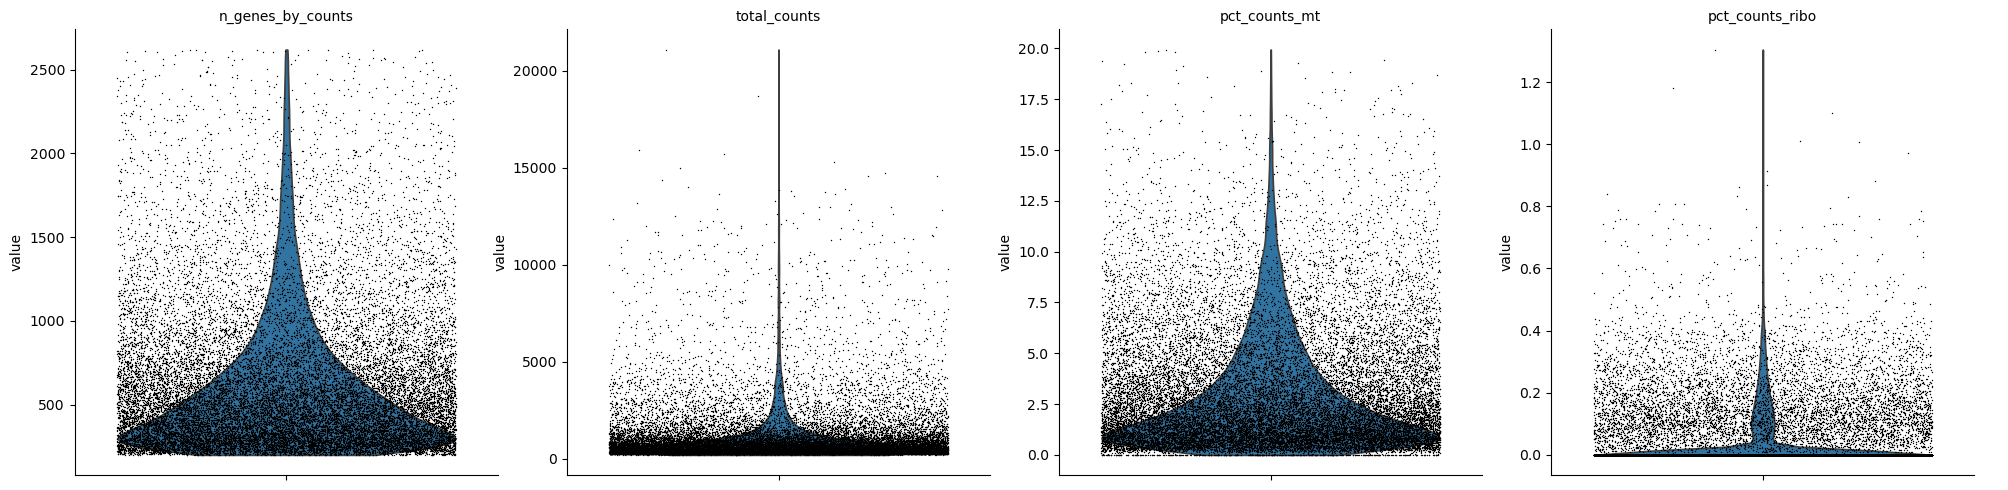

In [86]:
sc.pl.violin(p5_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

In [81]:
upper_lim = np.quantile(p5_adata.obs.n_genes_by_counts.values, .98)

In [82]:
upper_lim

2620.0

In [85]:
p5_adata = p5_adata[p5_adata.obs.n_genes_by_counts < upper_lim]
p5_adata.obs
p5_adata = p5_adata[p5_adata.obs.pct_counts_mt < 20]
p5_adata = p5_adata[p5_adata.obs.pct_counts_ribo < 2]

In [ ]:
## Normalization

In [89]:
p5_adata.X.sum(axis = 1)

matrix([[575.4263 ],
        [239.164  ],
        [356.44986],
        ...,
        [250.35527],
        [300.76813],
        [319.46378]], dtype=float32)

In [90]:
sc.pp.normalize_total(p5_adata, target_sum=1e4)

In [91]:
p5_adata.X.sum(axis = 1)

matrix([[10000.001],
        [10000.001],
        [10000.003],
        ...,
        [10000.   ],
        [10000.   ],
        [ 9999.999]], dtype=float32)

In [92]:
sc.pp.log1p(p5_adata) #change to log counts

In [94]:
p5_adata.X.sum(axis = 1)

matrix([[1905.8422],
        [1101.0134],
        [1453.6997],
        ...,
        [1151.0032],
        [1151.5999],
        [1377.302 ]], dtype=float32)

In [95]:
p5_adata.raw = adata

In [ ]:
## Clustering 

In [96]:
sc.pp.highly_variable_genes(p5_adata, n_top_genes = 2000)


In [97]:
p5_adata.var

,gene_ids,feature_types,genome,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
SAMD11,ENSG00000187634,Gene Expression,GRCh38,False,False,45,0.001980,99.825256,51.0,44,False,0.031515,3.217341,0.675113
NOC2L,ENSG00000188976,Gene Expression,GRCh38,False,False,1131,0.051763,95.608108,1333.0,1127,False,0.425986,2.994279,-0.518294
KLHL17,ENSG00000187961,Gene Expression,GRCh38,False,False,260,0.010407,98.990370,268.0,260,False,0.140725,3.053907,-0.021608
PLEKHN1,ENSG00000187583,Gene Expression,GRCh38,False,False,361,0.015261,98.598167,393.0,357,False,0.159674,3.000485,-0.249348
PERM1,ENSG00000187642,Gene Expression,GRCh38,False,False,7,0.000272,99.972818,7.0,7,False,0.002783,3.122892,0.272476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4L,ENSG00000212907,Gene Expression,GRCh38,True,False,16763,2.713187,34.906027,69870.0,16415,False,2.961941,2.920715,-0.564028
MT-ND4,ENSG00000198886,Gene Expression,GRCh38,True,False,17382,3.449868,32.502330,88841.0,16996,False,3.087720,3.001663,-0.939525
MT-ND5,ENSG00000198786,Gene Expression,GRCh38,True,False,11440,1.250311,55.576266,32198.0,11243,False,2.375737,2.981355,-1.044224
MT-ND6,ENSG00000198695,Gene Expression,GRCh38,True,False,12616,1.480468,51.009630,38125.0,12390,False,2.515949,2.984081,-0.527924


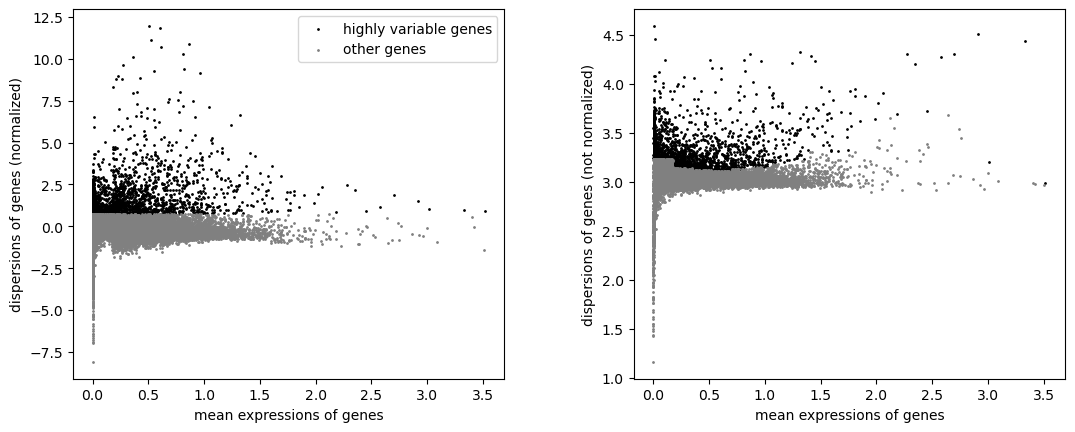

In [98]:
sc.pl.highly_variable_genes(p5_adata)


In [101]:
p5_adata = p5_adata[:, p5_adata.var.highly_variable]

In [102]:
sc.pp.regress_out(p5_adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])


/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:729: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [103]:
sc.pp.scale(p5_adata, max_value=10)

In [104]:
sc.tl.pca(p5_adata, svd_solver='arpack')


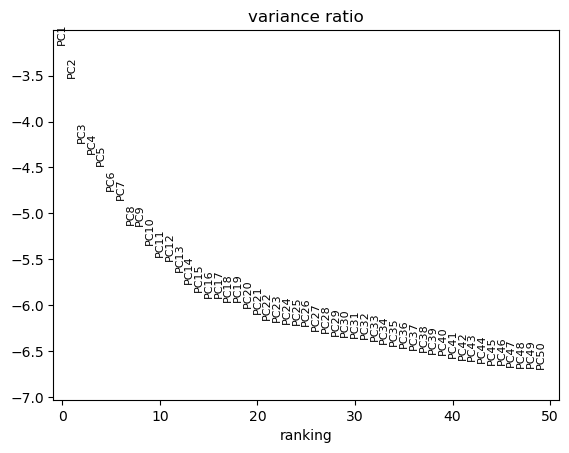

In [105]:
sc.pl.pca_variance_ratio(p5_adata, log=True, n_pcs = 50)


In [106]:
sc.pp.neighbors(p5_adata, n_pcs = 30)

In [107]:
sc.tl.pca(p5_adata, svd_solver='arpack')


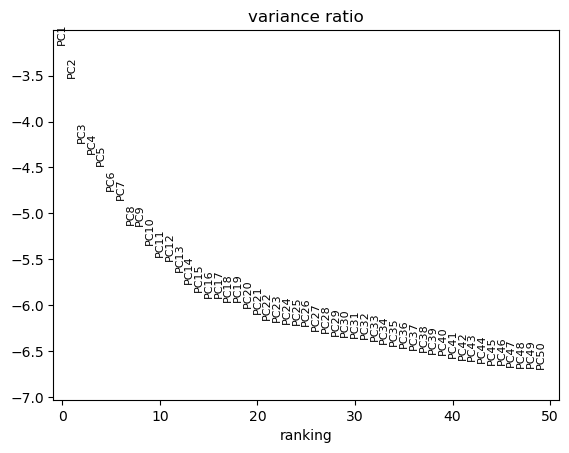

In [108]:
sc.pl.pca_variance_ratio(p5_adata, log=True, n_pcs = 50)


In [109]:
sc.pp.neighbors(p5_adata, n_pcs = 30)

In [110]:
sc.tl.umap(p5_adata)

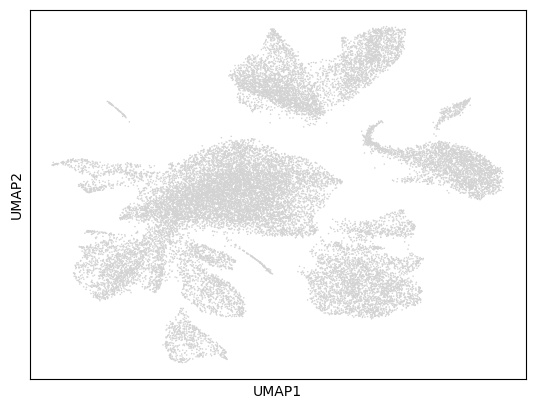

In [111]:
sc.pl.umap(p5_adata)

In [114]:
sc.tl.leiden(p5_adata, resolution = 0.5)


In [113]:
p5_adata.obs


,suffix,sample_id,patient_tag,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes,leiden
AAACAAGCAACAGCTAACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,False,715,1914.0,33.0,1.724138,0.0,0.000000,715,4
AAACAAGCAACTGTTCACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,False,318,369.0,4.0,1.084011,0.0,0.000000,318,2
AAACAAGCAAGGCCTGACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,False,472,556.0,35.0,6.294964,1.0,0.179856,472,1
AAACAAGCAGGGCTATACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,False,935,1223.0,38.0,3.107114,1.0,0.081766,935,2
AAACAAGCATTGTGAGACTTTAGG-1,1,20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC...,P2CRC,False,267,296.0,4.0,1.351351,0.0,0.000000,267,1
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGCGGTTAGTGCTACTTTAGG-7,7,20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC...,P2CRC,False,696,897.0,13.0,1.449275,0.0,0.000000,696,7
TTTGGCGGTTCCGGGTACTTTAGG-7,7,20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC...,P2CRC,False,236,255.0,4.0,1.568628,0.0,0.000000,236,0
TTTGTGAGTCCGCTAAACTTTAGG-7,7,20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC...,P2CRC,False,338,383.0,15.0,3.916449,0.0,0.000000,338,0
TTTGTGAGTCCGGGTTACTTTAGG-7,7,20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC...,P2CRC,False,346,649.0,22.0,3.389831,2.0,0.308166,346,3


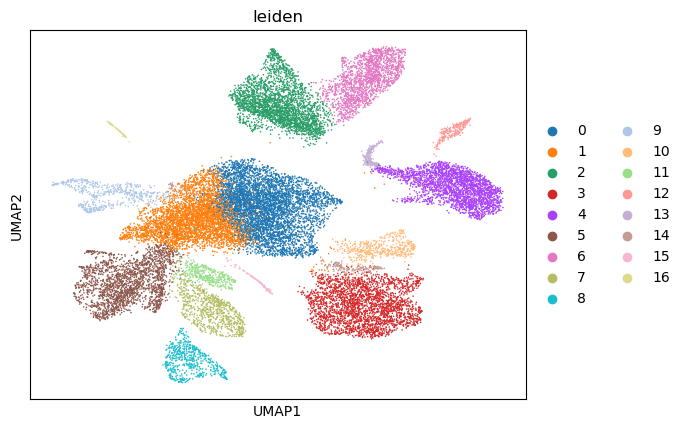

In [115]:
sc.pl.umap(p5_adata, color=['leiden'])

In [ ]:
# Integration 

